Attach Google disk

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Prepare environment 

In [ ]:
pip install statsmodels==0.12.1 # install proper version of STL

In [3]:
import os
import datetime
import shutil

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import feature_column
from pandas import read_csv
from pandas import DataFrame
from keras.utils import to_categorical
from tensorflow.keras import layers
# from tensorboard.plugins.hparams import api as hp # the TensorBoard HParams plugin

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
import tempfile
import PIL
from PIL import Image
import pathlib
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

from statsmodels.tsa.seasonal import STL

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

val_performance = {}
performance = {}

# Load the TensorBoard notebook extension
%load_ext tensorboard

tf.__version__

'2.4.1'

# Load data

In [4]:
#Date parser to ISO format
def parser(x):
 return datetime.datetime.strptime(x,'%d/%m/%Y')

df = read_csv('/content/drive/My Drive/Colab Notebooks/20 Weather Forecast/Data/data.csv', parse_dates=[1], date_parser=parser,)
df = df[['date','avgtempC','totalprecipMM','windspeedKmph','winddirdegree','weatherCode','humidity','visibilityKm','pressureMB','cloudcover']]

#Transforming Date to be used in STL model
date_np = df.pop('date')
date_np = date_np.dt.strftime('%Y-%m-%d')
df['date']= date_np 
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1] # move col Date from the last element to the first position:
df = df[cols]

# Data exploration

In [ ]:
# Inspect
df.describe().transpose()

Convert the wind direction and velocity columns to a wind vector

In [5]:
wv = df.pop('windspeedKmph')

# Convert to radians.
wd_rad = df.pop('winddirdegree')*np.pi / 180

# Calculate the wind x and y components.
df['wind_X_km_h'] = wv*np.cos(wd_rad)
df['wind_Y_km_h'] = wv*np.sin(wd_rad)

# Seasonal-Trend Decomposition using LOESS (STL) and features creation



In [6]:
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    seasonal, trend, resid = result.seasonal, result.trend, result.resid
    
    results_df = DataFrame({"seasonal":seasonal,
                               "trend":trend,
                               "resid":resid})

    #Reordering...
    results_df = results_df[["seasonal","trend","resid"]]
    
    # Table creating
    results_df.to_csv('results_df.csv')
    
    return results_df
    

if len(df.columns) < 38: # check not to create features once more 

  for column_name in df.columns[1:]: # interate across dataframe columns
    #date_np = df['date'].dt.strftime('%Y-%m-%d')
    season, feature = df['date'],df[column_name]# copy columns into np arrays: 'date' vs 'season'
    df_fts = pd.DataFrame({'date':season, column_name:feature}) # create dataframe from np arrays # 'date' vs 'season'
    
    #prepare dtaframe for processing in STL
    df_fts.set_index('date', inplace=True) #'date' vs 'season'
    df_fts = df_fts.asfreq(pd.infer_freq(df_fts.index))
    
    # Run STL
    stl = STL(df_fts)
    result = stl.fit()
    results_summary_to_dataframe(result)
    results_df=pd.read_csv('results_df.csv')
    
    #creating relevant columns
    column_name_1 = "%s%s" % (column_name, '_seasonal')
    column_name_2 = "%s%s" % (column_name, '_trend')
    column_name_3 = "%s%s" % (column_name, '_resid')
    df[column_name_1] = results_df['seasonal'].values
    df[column_name_2] = results_df['trend'].values
    df[column_name_3] = results_df['resid'].values

In [ ]:
df.describe().transpose()

# Correlation between different features

In [ ]:
# Functions definition 1/2
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[1]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

    # Execution 2/2
data = df.drop(['date'], axis=1)
fig, ax = plt.subplots(figsize=(15,15))
# Using matshow here just because it sets the ticks up nicely. imshow is faster.

im = ax.matshow(data.corr())#, cmap='seismic')

#Label sticks with the respective list entries
plt.xticks(range(data.shape[1]), data.columns, fontsize=10, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(data.shape[1]), data.columns, fontsize=10)

 # Create colorbar
cbarlabel="correlation coeff."
cbar = ax.figure.colorbar(im)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

def func(x, pos):
    return "{:.2f}".format(x).replace("0.", ".").replace("1.00", "")

annotate_heatmap(im, valfmt=mpl.ticker.FuncFormatter(func), size=8)

plt.show()

In [8]:
# Keep highly correlated features only
df  = df [['date', 'avgtempC', 'weatherCode','humidity','cloudcover','cloudcover_trend','humidity_trend','avgtempC_trend' , 'visibilityKm_trend']]#, 'season']]
#print(df.dtypes)

Bucketizing, one-hot encoding

In [9]:
# Season bucketizing
seasontype = []
for d in df['date']:
 dmonth=datetime.datetime.strptime(d, "%Y-%m-%d").month
 if dmonth ==12 or dmonth==1 or dmonth==2: seasont = 'winter'
 elif dmonth ==9 or dmonth==10 or dmonth==11: seasont = 'fall'
 elif dmonth ==6 or dmonth==7 or dmonth==8: seasont= 'summer'
 else: seasont= 'spring'
 seasontype.append(seasont)
season_name = pd.DataFrame(seasontype)

# Weather code bucketizing
weather=[]
#weather_name = {'Snow': 1,'Cloudy':2, 'Fog':3, 'Sunny':4, 'Rain':5 }
for w in df['weatherCode']:
 if w==230 or w== 317 or w==323 or w==326 or w==329 or w==332 or w==338 or w==368: weatherc= 'snow'
 elif w==116 or w == 119 or w==122: weatherc='cloudy'
 elif w==143 or w == 248 or w==260: weatherc= 'fog'
 elif w==113: weatherc= 'sunny'
 elif w==176 or w==200 or w==263 or w==266 or w==293 or w ==296 or w==299 or w==302 or w==308 or w==353 or w==356 or w==386: weatherc='rain'
 else: print ("Check weatherCode vocabulary")
 weather.append(weatherc)
weather_name = pd.DataFrame(weather)

## Cloudcover  bucketizing
cloudcover=[]
for c in df['cloudcover']:
 if c<33: cloudcoverc=0 # 0-33%
 elif c>=33 and c< 65 : cloudcoverc=1 # 34-66% 
 else: cloudcoverc=2 # 66- 100%
 cloudcover.append(cloudcoverc)
cloudcover_bucket = pd.DataFrame(cloudcover, columns= ['cloudcover bucket'])

#One hot features
one_hot_encoder = OneHotEncoder(sparse=False)

one_hot_encoder.fit(season_name)
x = pd.DataFrame(seasontype)
y1= one_hot_encoder.transform(x)
y1=pd.DataFrame(data=y1, columns=one_hot_encoder.categories_)

one_hot_encoder.fit(weather_name)
x = pd.DataFrame(weather)
y2= one_hot_encoder.transform(x)
y2=pd.DataFrame(data=y2, columns=one_hot_encoder.categories_)

one_hot_encoder.fit(cloudcover_bucket)
x = pd.DataFrame(cloudcover_bucket)
y3=one_hot_encoder.transform(x)
y3=pd.DataFrame(data=y3, columns=one_hot_encoder.categories_)

#Update Data frame
df=pd.concat([df,cloudcover_bucket, y1,y2,y3], axis=1)

df = df.drop(['date', 'weatherCode', 'cloudcover'], axis = 1)

**Split the data**

We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

*   It ensures that chopping the data into windows of consecutive samples is still possible.
*   It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained



In [10]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

#Define data input shape
num_features = train_df.shape[1]

#Convert Multi data type to single data type to avoid SettingWithCopyWarning in normalization
train_df=train_df.astype({'humidity':'float64','cloudcover_trend':'float64',
                          'humidity_trend':'float64', 'avgtempC_trend':'float64','visibilityKm_trend':'float64'})
val_df=val_df.astype({'humidity':'float64','cloudcover_trend':'float64',
                      'humidity_trend':'float64', 'avgtempC_trend':'float64','visibilityKm_trend':'float64'})
test_df=test_df.astype({'humidity':'float64','cloudcover_trend':'float64',
                        'humidity_trend':'float64', 'avgtempC_trend':'float64','visibilityKm_trend':'float64'})
#print(train_df.head())

Standardization the data.

Standardization (Normalization) across instances should be done after splitting the data between training and test set, using only the data from the training set. This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages.

Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

In [11]:
for col in train_df.columns[1:6]:  # go through the selected columns
  # calculates the percentage change between the current and a prior element
  train_df.loc[:,col] = train_df[col].pct_change()  
  val_df.loc[:,col] = val_df[col].pct_change()  
  test_df.loc[:,col] = test_df[col].pct_change()
      
  # remove the NaNs and INf created by pct_change
  train_df.replace([np.inf, -np.inf], np.nan,inplace=True)   
  val_df.replace([np.inf, -np.inf], np.nan,inplace=True)  
  test_df.replace([np.inf, -np.inf], np.nan,inplace=True) 
    
  # scale between 0 and 1
  train_df.loc[:,col] = preprocessing.scale(train_df[col].values)  
  val_df.loc[:,col]  = preprocessing.scale(val_df[col].values)
  test_df.loc[:,col]  = preprocessing.scale(test_df[col].values)
  
# cleanup again
train_df.dropna(inplace=True) 
val_df.dropna(inplace=True)   
test_df.dropna(inplace=True) 

# Data windowing

1. Indexes and offsets

https://www.tensorflow.org/tutorials/structured_data/time_series#1_indexes_and_offsets

In [12]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)} # study this function
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

2. Split

In [13]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

3. Create tf.data.Datasets

In [14]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True, # !!!
      batch_size=128,)  # Dataset batchsize !!

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example # TBC!!!!


# MODELS

Models inputs

In [16]:
#Model parameters
batch_size = 28
epochs = 300

#Window parameters
input_width=14 # number of days as history to be fed into training per batch
shift = 1 # predict for 1 day
label_columnsT = ['avgtempC'] # to be predicted
label_columnsW= ['cloudcover bucket'] # to be predicted
num_labels = 1 #len(label_columns)

LR= 1e-4
LRD = 1e-5
label_width = num_labels


def get_optimizer():
  return tf.keras.optimizers.RMSprop(learning_rate=LR, decay=LRD)

def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=50,
                                              mode='min'),    
    ]                                   
       

def compile_and_fit_T(model, window): # for temperature prediction model

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=get_optimizer(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=get_callbacks())
  return history

def compile_and_fit_W(model, window): # for cloud cover density prediction model

  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(),
                optimizer=get_optimizer(),
                metrics=[tf.metrics.SparseCategoricalAccuracy()])

  history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=get_callbacks())
  return history



  %%time
wide_window_T = WindowGenerator( # for temperature prediction model
    input_width=input_width, label_width=label_width, shift=shift, label_columns=label_columnsT)

wide_window_W = WindowGenerator( # for cloud cover density prediction model
    input_width=input_width, label_width=label_width, shift=shift, label_columns=label_columnsW)


In [ ]:
# Temperature preidction 

CRNN_model_T = tf.keras.Sequential([  
    tf.keras.layers.Conv1D(140,
                           (2),
                           strides=1, padding="same",
                           activation='relu',
                           input_shape=(input_width, num_features)),
    tf.keras.layers.Conv1D(140,
                           (2),
                           strides=1, padding="same", 
                           activation='relu'), # relu
    tf.keras.layers.Conv1D(140,
                           (2),
                           strides=1, padding="same", 
                           activation='relu'), 
    tf.keras.layers.Conv1D(num_features,
                           (2),
                           strides=1, padding="same", 
                           activation='relu'), 
    tf.keras.layers.Reshape((input_width, num_features)),
    tf.keras.layers.LSTM(300, return_sequences=True),
    tf.keras.layers.LSTM(300, return_sequences=True),
    tf.keras.layers.LSTM(300, return_sequences=True),
    tf.keras.layers.LSTM(300, return_sequences=True),
    tf.keras.layers.LSTM(300, return_sequences=True),
    tf.keras.layers.LSTM(300, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(300, return_sequences=True),
    tf.keras.layers.Dense(units=1),

])

# Clear any logs from previous runs
shutil.rmtree('logs', ignore_errors=True)
shutil.rmtree('models', ignore_errors=True)

history = compile_and_fit_T(CRNN_model_T, wide_window_T)

IPython.display.clear_output()
val_performance['CNN'] = CRNN_model_T.evaluate( wide_window_T.val)
performance['CNN'] = CRNN_model_T.evaluate( wide_window_T.test, verbose=0)

In [ ]:
#Cloud cover density prediction 
CRNN_model_C = tf.keras.models.Sequential([ # Rename (align with Temperature)
    tf.keras.layers.Conv1D(40,
                           (1),
                           strides=1, padding="same", #same
                           activation='relu',
                           input_shape=(input_width, num_features)),
    tf.keras.layers.Conv1D(40,
                           (1),
                           strides=1, padding="same", #same
                           activation='relu'), # relu
    tf.keras.layers.Conv1D(num_features,
                           (1),
                           strides=1, padding="same", #same
                           activation='relu'), # relu
    tf.keras.layers.Reshape((input_width, num_features)),
    #Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Flatten(),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=3, activation='softmax') # 
   ])

# Clear any logs from previous runs
shutil.rmtree('logs', ignore_errors=True)
shutil.rmtree('models', ignore_errors=True)

history = compile_and_fit_W(CRNN_model_C, wide_window_W)

IPython.display.clear_output()
val_performance['CRNN Weather'] = CRNN_model_C.evaluate( wide_window_W.val)
performance['CRNN Weather'] = CRNN_model_C.evaluate( wide_window_W.test, verbose=0)

Cloud cover detection model

In [19]:
#Load pictures
# do not use figures only in filenames otherwise will get TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string. 

data_dir = pathlib.Path('/content/drive/My Drive/Colab Notebooks/20 Weather Forecast/Clouds/')
image_count = len(list(data_dir.glob('*/*.*')))

#Image sizing
img_height = 180
img_width = 180
chanDim=-1
batch_size = 32
history = {}

In [21]:
#Model parameteres
batch_size = 40
INIT_LR = 1e-4
epochs = 15
N_VALIDATION = int(200)
N_TRAIN = int(200)
STEPS_PER_EPOCH = N_TRAIN//batch_size
BUFFER_SIZE = int(1e3)
lr_schedule_P = tf.keras.optimizers.schedules.InverseTimeDecay(
  INIT_LR,
  decay_steps= STEPS_PER_EPOCH*1e4,
  decay_rate=1,
  staircase=False)

def get_optimizer_P():
  return tf.keras.optimizers.Adam(lr_schedule_P)

def get_callbacks_P():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.TensorBoard(logdir),
  ]

#Data split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

num_classes = len(train_ds.class_names)

Found 168 files belonging to 3 classes.
Using 135 files for training.
Found 168 files belonging to 3 classes.
Using 33 files for validation.


In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(30).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# DATASET AUGMENTATION

train_ds=train_ds.repeat(130)
val_ds=val_ds.repeat(130)

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomFlip("vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),    
  ]
)

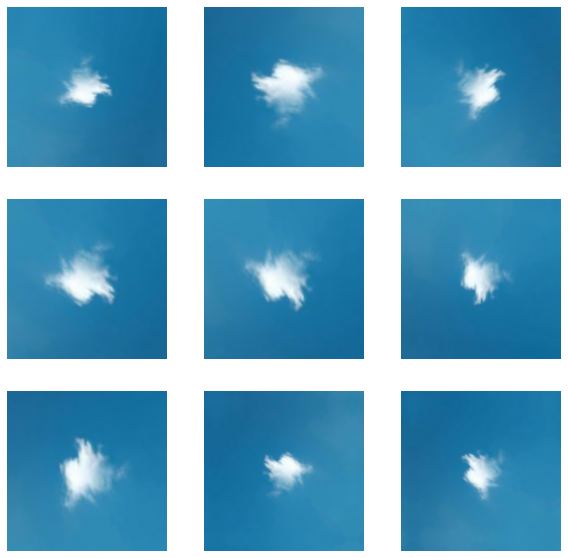

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [24]:
#Model for Cloud cover

Cloud_model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu',input_shape=(None,img_height,img_width,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu',  kernel_regularizer=regularizers.l2(0.001)),# regularizer
  #layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

def compile_and_fit_P(model, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer_P()
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #SparseCategoricalCrossentropy
              metrics=[tf.metrics.SparseCategoricalAccuracy()])
  
  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=get_callbacks_P(),
    verbose=0
    )
  return history

In [ ]:
history = compile_and_fit_P(Cloud_model)

IPython.display.clear_output()
val_performance['Cloud cover'] = Cloud_model.evaluate(val_ds)
performance['Cloud cover'] = Cloud_model.evaluate(train_ds, verbose=0)

In [ ]:
#Cloud cover Inference
pic_url1 =  pathlib.Path ('/content/drive/My Drive/Colab Notebooks/20 Weather Forecast/Picture_Input/')

for name in pic_url1.glob('*.*'): 
    print(name)
pic_url=name.as_posix()    

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

img = tf.io.read_file(pic_url)
img_array = decode_img(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [ ]:
predictions = Cloud_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

if np.argmax(predictions) == 0 : cv = ' Cloud cover less 33%' # try if class_names[np.argmax(score)] == 0 : cv = ' Cloud cover less 33%'
elif np.argmax(predictions) == 1: cv = 'Cloud cover 33-65 %'
else: cv = 'Cloud cover more 65 %'
cv1 = 100 * np.max(predictions)
print(
    "{} with a {:.2f} percent confidence."
    .format(cv, cv1)
)

Define inputs


In [30]:
#Current Temeperature manual input
print('Enter current temperature (C):')
temp = input()


Enter current temperature (C):
3


In [31]:
#Load data
def parser(x):
 return datetime.datetime.strptime(x,'%d/%m/%Y')

df_input = read_csv('/content/drive/My Drive/Colab Notebooks/20 Weather Forecast/Data/data.csv', parse_dates=[1], date_parser=parser,)
df_input = df_input[['date','avgtempC','totalprecipMM','windspeedKmph','winddirdegree','weatherCode','humidity','visibilityKm','pressureMB','cloudcover']]
df_input = df_input.tail(15) # last N+1 rows from actual data - must be equal to model width
input_width = len(df_input)-1

#Transforming Date to be used in STL model
date_np = df_input.pop('date')
date_np = date_np.dt.strftime('%Y-%m-%d')
df_input['date']= date_np 
cols = df_input.columns.tolist()
cols = cols[-1:] + cols[:-1] # move column Date from the last element to the first position:
df_input = df_input[cols]

#Convert the wind direction and velocity columns to a wind vector
wv = df_input.pop('windspeedKmph')

# Convert to radians.
wd_rad = df_input.pop('winddirdegree')*np.pi / 180

# Calculate the wind x and y components.
df_input['wind_X_km_h'] = wv*np.cos(wd_rad)
df_input['wind_Y_km_h'] = wv*np.sin(wd_rad)

# SLT model
if len(df_input.columns) < 38: # check not to create features once more 

  for column_name in df_input.columns[1:]: # interate across dataframe columns
    season, feature = df_input['date'],df_input[column_name]# copy columns into np arrays: 'date' vs 'season'
    df_fts = pd.DataFrame({'date':season, column_name:feature}) # create dataframe from np arrays # 'date' vs 'season'
    
    #prepare dtaframe for processing in STL
    df_fts.set_index('date', inplace=True) #'date' vs 'season'
    df_fts = df_fts.asfreq(pd.infer_freq(df_fts.index))
    
    # Run STL
    stl = STL(df_fts)
    result = stl.fit()
    results_summary_to_dataframe(result)
    results_df=pd.read_csv('results_df.csv')
    
    #creating relevant columns
    column_name_1 = "%s%s" % (column_name, '_seasonal')
    column_name_2 = "%s%s" % (column_name, '_trend')
    column_name_3 = "%s%s" % (column_name, '_resid')
    df_input[column_name_1] = results_df['seasonal'].values
    df_input[column_name_2] = results_df['trend'].values
    df_input[column_name_3] = results_df['resid'].values

# Keep highly correlated features only
df_input  = df_input [['date', 'avgtempC', 'weatherCode','humidity','cloudcover','cloudcover_trend','humidity_trend','avgtempC_trend' , 'visibilityKm_trend']]#, 'season']]


# Season bucketizing
df_input[['cloudcover bucket','fall', 'spring', 'summer', 'winter',  'cloudy', 'fog', 'rain', 'snow', 'sunny',  '0', '1', '2' ]] = 0 # create placeholders for 'manual'  one hot encoding


#Convert Multi data type to single data type to avoid SettingWithCopyWarning in normalization
#df_input=df_input.astype({'humidity':'float64','cloudcover_trend':'float64',
#                          'humidity_trend':'float64', 'avgtempC_trend':'float64','visibilityKm_trend':'float64'})
date= df_input.pop('date')
df_input=df_input.astype('float64')
df_input=pd.concat([df_input,date], axis=1)

df_input1=df_input[0:0] #clone df_input, empty it to creat df as placeholder for one hotted data

# Season and Weather One hot 

pd.options.mode.chained_assignment = None # disable false SettingwithCopyWarning
i=0
for d in df_input['date']:
  dmonth=datetime.datetime.strptime(d, "%Y-%m-%d").month
  w = df_input['weatherCode'].iloc[i] # mitigate numpy.data not iterable error
  c= df_input['cloudcover'].iloc[i] # mitigate numpy.data not iterable error
#Season one hot  
  if dmonth ==12 or dmonth==1 or dmonth==2: # Season loop 
    df_input['winter'],df_input['fall'],df_input['summer'],df_input['spring'] = 1,0,0,0
  elif dmonth ==9 or dmonth==10 or dmonth==11:
    df_input['fall'],df_input['summer'],df_input['winter'],df_input['spring'] = 1,0,0,0
  elif dmonth ==6 or dmonth==7 or dmonth==8:
    df_input['summer'], df_input['winter'], df_input['spring'], df_input['fall']   = 1,0,0,0
  else: 
    df_input['spring'],df_input['winter'], df_input['fall'], df_input['summer']   = 1,0,0,0

#Weather code one hot 
  if w ==230 or w== 317 or w==323 or w==326 or w==329 or w==332 or w==338 or w==368: 
    df_input['snow'], df_input['cloudy'],df_input['fog'],df_input['rain'],df_input['sunny'] = 1,0,0,0,0
  elif w==116 or w==119 or w==122: 
    df_input['cloudy'],df_input['snow'], df_input['fog'],df_input['rain'],df_input['sunny']= 1,0,0,0,0
  elif w==113: 
    df_input['sunny'],df_input['cloudy'],df_input['snow'], df_input['fog'],df_input['rain'] = 1,0,0,0,0
  elif w==143 or w == 248 or w==260: 
    df_input['fog'],df_input['sunny'],df_input['cloudy'],df_input['snow'], df_input['rain']= 1,0,0,0,0
  elif w==176 or w==200 or w==263 or w == 266 or w==293 or w ==296 or w==299 or w==302 or w==308 or w==353 or w==356: 
    df_input['rain'],df_input['fog'],df_input['sunny'], df_input['cloudy'],df_input['snow']= 1,0,0,0,0 
  else: print ("Check weatherCode vocabulary",w,unique_elements)

#Cloudcover bucketizing
  if c<33: 
    df_input['cloudcover bucket']=0 # 0-33%
    df_input['0'], df_input['1'], df_input['2'] = 1,0,0
  elif c>=33 and c< 65 : 
    df_input['cloudcover bucket']=1 # 34-65%
    df_input['0'], df_input['1'], df_input['2'] = 0,1,0   
  else: 
    df_input['cloudcover bucket']=2 # 66- 100%
    df_input['0'], df_input['1'], df_input['2'] = 0,0,1

  df_input1.loc[df_input.index[i]]=df_input.iloc[i]
  i += 1

pd.options.mode.chained_assignment = 'warn' # enable  SettingwithCopyWarning

df_input=df_input1
df_input = df_input.drop(['weatherCode', 'cloudcover', 'date'], axis = 1)

#Normalization
for col in df_input.columns[1:6]:  # go through selected columns
  df_input.loc[:,col] = df_input[col].pct_change()  # calculates the percentage change between the current and a prior element
        
  # remove the NaNs and INf created by pct_change
  df_input.replace([np.inf, -np.inf], np.nan,inplace=True)   
    
  # scale between 0 and 1
  df_input.loc[:,col] = preprocessing.scale(df_input[col].values)  
  
# cleanup again
df_input.dropna(inplace=True)

#Reshape dataframe to fit the model shape
df_input1=df_input.values.reshape(1,input_width,19) # 20 - number of columns

# replace last row with actual data
df_input.iloc[13]['avgtempC'] = temp
df_input.iloc[13]['cloudcover bucket'] = np.argmax(predictions)

In [ ]:
# Temperature inference
predictions_CNN = CRNN_model_T.predict(df_input1)
prediction_CNN = predictions_CNN.reshape(14,1) # reshape to fit Dataframe - check window width
prediction_CNN = pd.DataFrame(prediction_CNN, columns=['avgtempC'])

label_columns = 'avgtempC'
label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
column_indices = {name: i for i, name in
                          enumerate(df_input.columns)}

label_columns = 'avgtempC'
inputs = df_input1
label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
column_indices = {name: i for i, name in
                          enumerate(df_input.columns)}

label_index=column_indices['avgtempC']
input_slice = slice(0,input_width)
input_indices = np.arange(input_width)[input_slice]
output_slice = slice(1,input_width+1)
output_indices = np.arange(input_width+1)[output_slice]
plot_col= label_columns
plot_col_index = column_indices[plot_col]
plt.figure(figsize=(12, 8))
plt.ylabel(f'{plot_col}')
label_col_index = label_columns_indices.get(plot_col, None)
plt.plot(input_indices, inputs[0, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
col_index = label_columns_indices.get(plot_col, None)
plt.scatter(output_indices, predictions_CNN[0, :, label_col_index],
                  marker='D', edgecolors='k', label='Predictions CNN',
                  c='#ff7f0e', s=64)
plt.legend()
plt.xlabel('Days')

In [ ]:
#Cloudcover inference

predictions_CRNN = CRNN_model_C.predict(df_input1)
prediction_CRNN=predictions_CRNN.reshape(3,1) # reshape to fit Dataframe - check window width
prediction_CRNN = pd.DataFrame(prediction_CRNN, columns=['cloudcover bucket'])

if np.argmax(prediction_CRNN) == 0 : cv = ' Cloud cover less 33%'
elif np.argmax(prediction_CRNN) == 1: cv = 'Cloud cover 33-65 %'
else: cv = 'Cloud cover more 65 %'
cv1 = 100 * np.max(prediction_CRNN.values)
print(
    "{} with a {:.2f} percent confidence."
    .format(cv, cv1)
)
